In [1]:
# ensure classes imported from .py files are dynamically updated
%load_ext autoreload
%autoreload 2

# plot matplots nicely
%matplotlib inline  

In [11]:
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
import cmocean

# load pre-built data classes
from steric_height import StericHeight
from plotting_fns import PlottingFns as pfns
from utils import Utils as utls
from region import Region as rg
from data_handler import *


pfns = pfns()

In [3]:
dot_ds = DOT().ds
lwe_ds = GRACE().ds
msl_ds = ERA5().ds

sha = StericHeight(ssh_ref='DOT',
                   ssh=dot_ds.dot,
                   lwe=lwe_ds.lwe_thickness,
                   msl=msl_ds.msl
                  ).get_sha()

gpha = GPHA()

In [4]:
sta = dot_ds.time[0]
fin = dot_ds.time[-1]

In [5]:
# get hi res GEBCO
gebco_coarse = GEBCO(coarsen_factor=40).ds
gebco_fine = GEBCO(coarsen_factor=10).ds

In [6]:
profiles = gpha.profile_df
profiles_argo = profiles[profiles.float_type=='ARGO']
profiles_meop = profiles[profiles.float_type=='MEOP']
profiles_gridded = gpha.gridded_ds

In [7]:
sha_gph = xr.merge([sha,profiles_gridded])

In [8]:
sha_gph['profile_gpha'] = 100*(sha_gph.profile_gph - sha_gph.profile_gph.sel(time=slice(sta,fin)).mean('time'))

In [9]:
n_profiles = (~np.isnan(sha_gph.profile_gpha)).sum('time')
sha_corr = sha_gph.sha.where(n_profiles > 6, drop = True)
gph_corr = sha_gph.profile_gpha.where(n_profiles > 6, drop = True)

Text(0.0, 1.0, '(e)')

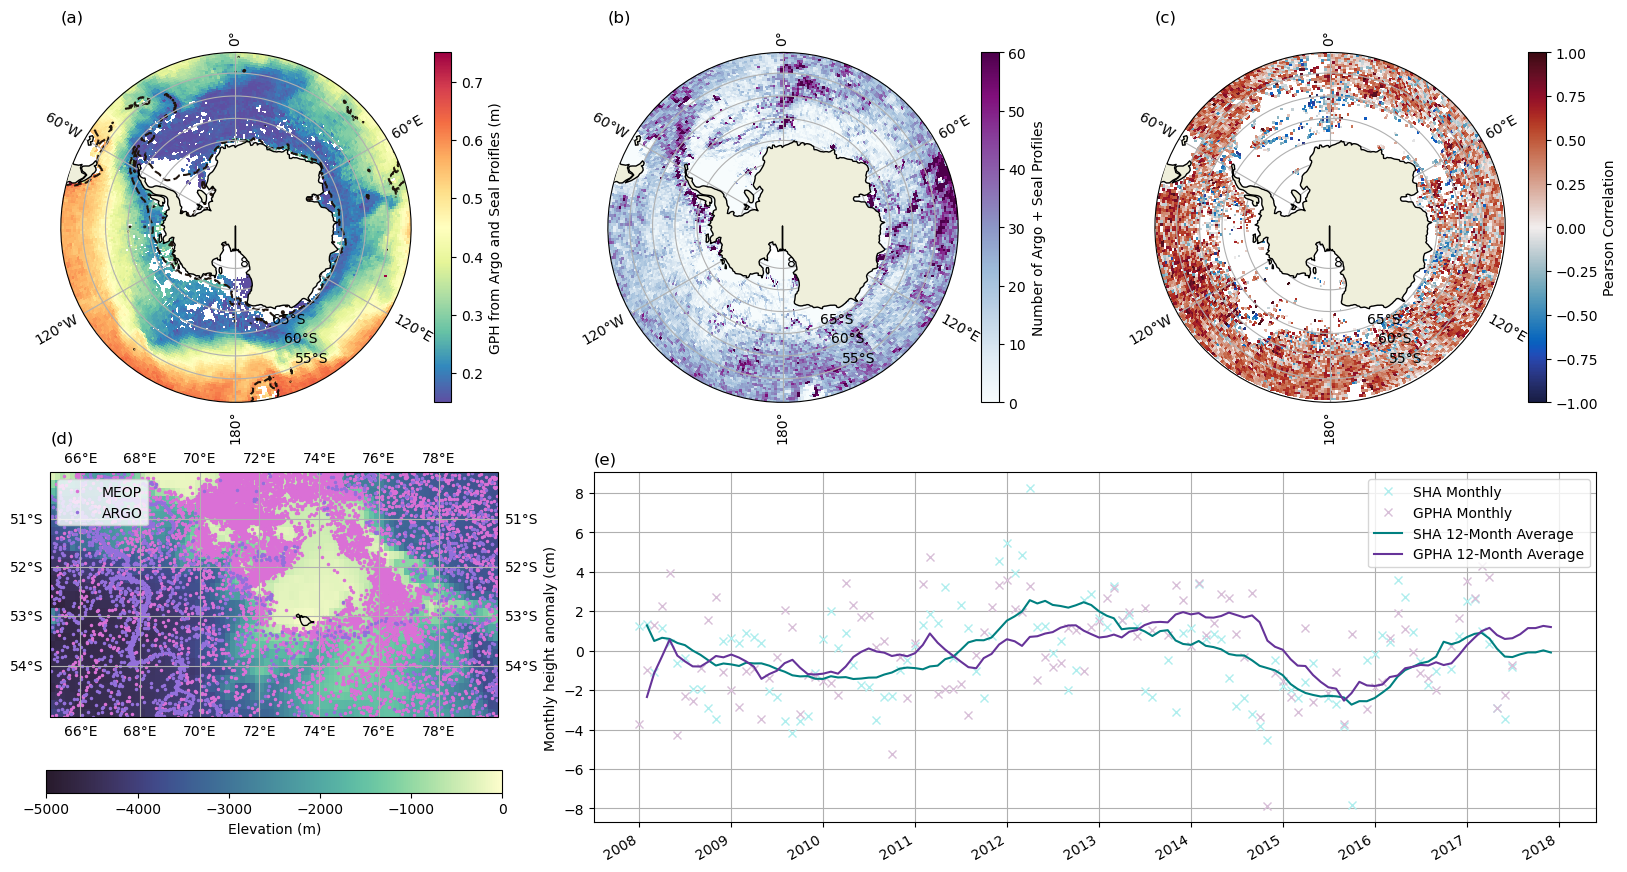

In [12]:
#fig,axs = plt.subplots(1,3,figsize=(20,5),subplot_kw={'projection': ccrs.SouthPolarStereo()})

fig = plt.figure(figsize=(20,10))
axs=[]

gs = fig.add_gridspec(2,3)#,height_ratios=[1,2])
axs.append(fig.add_subplot(gs[0, 0],projection=ccrs.SouthPolarStereo()))
axs.append(fig.add_subplot(gs[0, 1],projection=ccrs.SouthPolarStereo()))
axs.append(fig.add_subplot(gs[0, 2],projection=ccrs.SouthPolarStereo()))
axs.append(fig.add_subplot(gs[1, 0],projection=ccrs.Mercator()))
axs.append(fig.add_subplot(gs[1, 1:3]))

pfns.sp(axs[0],profiles_gridded.profile_gph.mean(('time')),vmin=.15,vmax=.75,cbar="GPH from Argo and Seal Proifles (m)",bathy=gebco_coarse.elevation,cbar_orientation='vertical')
axs[0].set_title('(a)',loc='left')

pfns.sp(axs[1],sha_gph.profile_cnt.sum(('time')),vmin=0,vmax=60,cbar="Number of Argo + Seal Profiles",cmap='BuPu',cbar_orientation='vertical')
axs[1].set_title('(b)',loc='left')

# pfns.sp(axs[1],pval,cbar="pVal",cmap='BuPu',cbar_orientation='vertical')
# axs[1].set_title('(b)',loc='left')

pfns.sp(axs[2],xr.corr(sha_corr,gph_corr,dim='time'),cmap=cmocean.cm.balance,cbar='Pearson Correlation',cbar_orientation='vertical')
axs[2].set_title('(c)',loc='left')

sample_rg = rg('Sample Region', [65,80,-55,-50])# [68,78,-53.5,-50])

sample_rg.plot_profiles_for_region(gebco_coarse,profiles_meop,profiles_argo,sta,fin, figsize=(6,5), fig=fig, ax=axs[3])
axs[3].set_title('(d)',loc='left')
#fig.savefig('plots/figure3d.png',dpi=200,transparent=True,bbox_inches='tight')


sample_rg.timeseries_compare(sha_gph,annual=False,fig=fig,ax=axs[4])
axs[4].set_title('(e)',loc='left')
#fig.savefig('plots/figure3e.png',dpi=200,transparent=True,bbox_inches='tight')


#fig.savefig('plots/figure3abc.png',dpi=200,transparent=True,bbox_inches='tight')



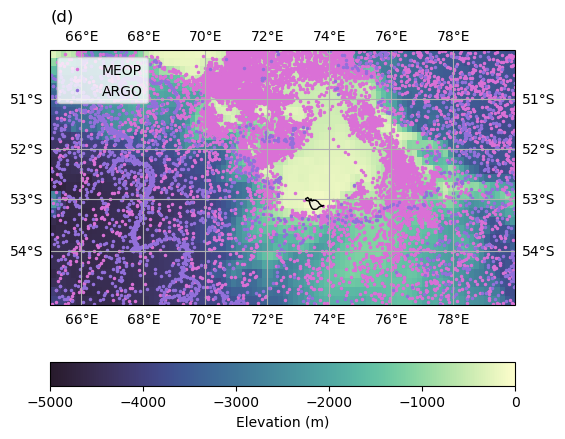

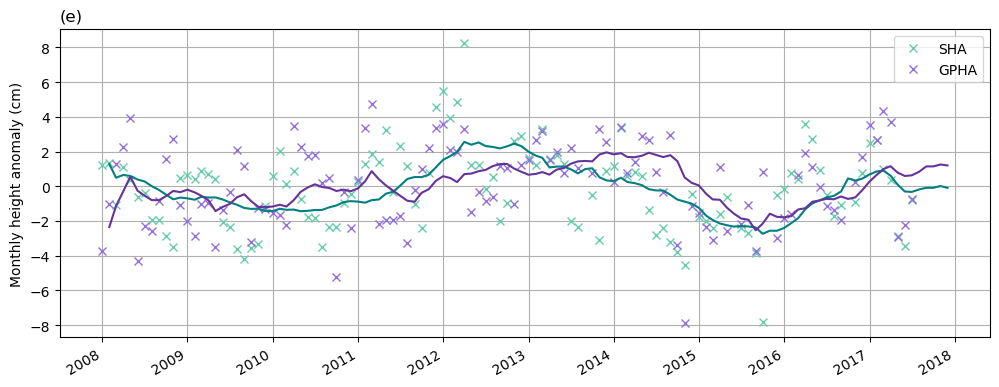

In [40]:
#fig,ax = plt.subplots(figsize=(7,5),subplot_kw={'projection': ccrs.Mercator()})

#pfns.sp(ax,xr.corr(sha_corr,gph_corr,dim='time'),sea='Seal Island',cmap=cmocean.cm.balance,cbar='Pearson Correlation',cbar_orientation='vertical')
sample_rg = rg('Sample Region', [65,80,-55,-50])# [68,78,-53.5,-50])

fig,ax = sample_rg.plot_profiles_for_region(gebco_coarse,profiles_meop,profiles_argo,sta,fin, figsize=(6,5))
ax.set_title('(d)',loc='left')
fig.savefig('plots/figure3d.png',dpi=200,transparent=True,bbox_inches='tight')


fig, ax = sample_rg.timeseries_compare(sha_gph,annual=False)
ax.set_title('(e)',loc='left')
fig.savefig('plots/figure3e.png',dpi=200,transparent=True,bbox_inches='tight')


# fig, ax = sample_rg.timeseries_compare(sha_gph,annual=False,sha_lbl='sha_grace_only')
# ax.set_title('(e)',loc='left')

In [18]:
def timeseries_with_cmt(region):
    
    ds = region.crop_da(sha_gph)
    fig, axs = plt.subplots(4,2,figsize=(16,10),gridspec_kw={'width_ratios': [2,1]})

    data_monthly = ds.where(~np.isnan(ds.sha))
    data_monthly_mean = data_monthly.mean(['latitude','longitude'])
    
    # climatology
    cmt = data_monthly.groupby('time.month').mean('time',skipna=True)
    cmt_mean = cmt.mean(['latitude','longitude'])

    #
    def plot_monthly(ax,var,c,cl,ylabel,mkr='-'):
        ax.plot(data_monthly.time,data_monthly_mean[var].to_numpy(),mkr,c=c)
        ax.plot(data_monthly.time,data_monthly_mean[var].rolling(time=12,min_periods=6).mean(),'-',c=cl)
        ax.set_ylabel(ylabel)
        ax.grid()
        
    def plot_climatology(ax,var,c,cl,mkr='-'):
        for grp in data_monthly_mean.groupby('time.year'):
            data = grp[1].groupby('time.month').mean()
            ax.plot(data.month,data[var],mkr,label=grp[0],c=cl)
        ax.plot(cmt.month,cmt_mean[var].to_numpy(),'-',c=c)
        ax.set_xticks(np.arange(1,13))
        ax.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
        ax.set_xlim([0.5,12.5])
        ax.grid()
    
    plot_monthly(axs[0][0],'ssha',c_dota_l,c_dota,'DOTA')
    plot_monthly(axs[1][0],'eha',c_grace_l,c_grace,'EHA')
    plot_monthly(axs[2][0],'sha',c_altimetry_l,c_altimetry,'SHA')
    plot_monthly(axs[3][0],'profile_gpha',c_profiles_l,c_profiles,'GPHA',mkr='x')
    
    plot_climatology(axs[0][1],'ssha',c_dota,c_dota_l)
    plot_climatology(axs[1][1],'eha',c_grace,c_grace_l)
    plot_climatology(axs[2][1],'sha',c_altimetry,c_altimetry_l)
    plot_climatology(axs[3][1],'profile_gpha',c_profiles,c_profiles_l,mkr='x')
    
    
    return fig, axs


In [19]:
def climatology_bar(region,useall=False):
    
    # crop sh dataset to region
    ds = region.crop_da(sha_gph)
    
    # crop profile dataframes to region (to get numbers)
    if not useall:
        # crop to region within satellite data time limits
        meop_crop = region.crop_df(profiles_meop[(profiles_meop.index > pd.to_datetime(sta.item())) & (profiles_meop.index < pd.to_datetime(fin.item()))])
        argo_crop = region.crop_df(profiles_argo[(profiles_argo.index > pd.to_datetime(sta.item())) & (profiles_argo.index < pd.to_datetime(fin.item()))])
    else:
        meop_crop = region.crop_df(profiles_meop)
        argo_crop = region.crop_df(profiles_argo)
    
    # get numbers of profiles
    months = np.arange(1,13)
    counts = lambda df: [len(df[df.index.month==m]) for m in months]
    n_meop = counts(meop_crop)
    n_argo = counts(argo_crop)
    
    # only include values where we have both profile and sha data
    if useall:
        data_masked = ds.where(~np.isnan(ds.profile_gpha))
    else:
        data_masked = ds.where(~np.isnan(ds.profile_gpha) & ~np.isnan(ds.sha))
        
    # compute detrended timeseries' for better climatology
    ds = ds.assign(gph_detrended = utls.detrend_dim(ds.profile_gpha, 'time', deg=1))
    ds = ds.assign(sha_detrended = utls.detrend_dim(ds.sha, 'time', deg=1))
    ds = ds.assign(ssha_detrended = utls.detrend_dim(ds.ssha, 'time', deg=1))
    
    
    climatology = ds.groupby('time.month').mean('time',skipna=True)

    fig, axs = plt.subplots(2,1,figsize=(12,7),gridspec_kw={'height_ratios': [1,1.5]})

    data = climatology.mean(['latitude','longitude'])
    counts = climatology.profile_cnt.sum(['latitude','longitude']).to_numpy()
    
    pfns.climatology(axs[0],[data.sha_detrended.to_numpy(),data.ssha_detrended.to_numpy(),data.gph_detrended.to_numpy()],['SHA','SSH','GPHA'],[c_altimetry,c_dota,c_profiles],twinx=False)

    w=0.6
    axs[1].bar(months, n_meop, w, label='All MEOP profiles', color=c_meop)
    axs[1].bar(months, n_argo,w, label='All ARGO profiles', bottom=n_meop, color=c_soccom)

    axs[1].grid()
    axs[1].set_xticks(months, ['J','F','M','A','M','J','J','A','S','O','N','D'])
    axs[1].legend(loc='best')
    axs[1].set_ylabel('Number of profiles')

    return fig


In [24]:
def timeseries_bar(region,annual=True,useall=False):
    
    ds = region.crop_da(sha_gph)
    if useall:
        ds = ds.sel(time=slice('2008-04-01','2022-03-31'))
    else:
        ds = ds.sel(time=slice('2008-01-01','2017-12-31'))
    
    fig, axs = plt.subplots(2,1,figsize=(12,6))

    # restrict altimetry to only where there are profiles
    if useall:
        data_masked = ds.where(~np.isnan(ds.profile_gpha))
    else:
        data_masked = ds.where(~np.isnan(ds.profile_gpha) & ~np.isnan(ds.sha))
            
    # take annual mean
    data_spatial = data_masked.groupby('time.year').mean('time',skipna=True) if annual else data_masked

    # spatial average
    data = data_spatial.mean(['latitude','longitude'])
    
    # sum counts for bar plot
    counts_annual = data_spatial.profile_cnt.sum(['latitude','longitude']).to_numpy()
    
    plot_time = data.year if annual else data.time
    
    if not annual:
        counts_monthly = data_masked.profile_cnt.sum(['latitude','longitude']).to_numpy()
        counts_quarterly = sum(counts_monthly.reshape([3,int(len(counts_monthly)/3)]))
        time_quarterly = data.time.to_numpy().reshape([int(len(counts_monthly)/3),3])[:,1]
    
    # plot sh and gph on different axes
    def plot(ax,var,c,title,marker='x-'):
        ax.plot(plot_time,data[var].to_numpy(),marker,c=c,label=title)
        
    
    # plot bar to show number of profiles
    if annual:
        plot(axs[0],'sha',c_altimetry,'SHA')
        plot(axs[0],'profile_gpha',c_profiles,'GPH')
        axs[0].grid()
        axs[0].legend()
        axs[0].set_ylabel('Annual height anomaly (cm)')
        axs[1].bar(plot_time,counts_annual,color=c_profiles)
        axs[1].set_ylabel('Number of profiles')
        axs[1].grid()
        axs[1].set_xlim(axs[0].get_xlim())
    else:
        plot(axs[0],'sha',c_altimetry_l,'SHA',marker='x')
        plot(axs[0],'profile_gpha',c_profiles_l,'GPHA',marker='x')
        axs[0].legend()
        data.sha.rolling(time=3,min_periods=2).mean().plot(ax=axs[0],label="SHA 12-Mo. Moving Av.",c=c_altimetry)
        data.profile_gpha.rolling(time=3,min_periods=2).mean().plot(ax=axs[0],label="GPHA 12-Mo. Moving Av.",c=c_profiles)
        axs[0].grid()
        axs[0].set_ylabel('Monthly height anomaly (cm)')
        
        axs[1].bar(np.arange(len(counts_quarterly)),counts_quarterly,color=c_profiles_l)
        axs[1].set_ylabel('Number of profiles')
        axs[1].grid()
        axs[1].set_xticks(np.arange(len(counts_quarterly))[::4])
        axs[1].set_xticklabels(map(lambda t: pd.to_datetime(t).strftime('%m-%Y'),time_quarterly[::4]))
    
    return fig, axs


In [21]:
def climatology_bar(region,useall=False):
    
    # crop sh dataset to region
    ds = region.crop_da(sha_gph)
    
    # crop profile dataframes to region (to get numbers)
    if not useall:
        # crop to region within satellite data time limits
        meop_crop = region.crop_df(profiles_meop[(profiles_meop.index > pd.to_datetime(sta.item())) & (profiles_meop.index < pd.to_datetime(fin.item()))])
        argo_crop = region.crop_df(profiles_argo[(profiles_argo.index > pd.to_datetime(sta.item())) & (profiles_argo.index < pd.to_datetime(fin.item()))])
    else:
        meop_crop = region.crop_df(profiles_meop)
        argo_crop = region.crop_df(profiles_argo)
    
    # get numbers of profiles
    months = np.arange(1,13)
    counts = lambda df: [len(df[df.index.month==m]) for m in months]
    n_meop = counts(meop_crop)
    n_argo = counts(argo_crop)
    
    # only include values where we have both profile and sha data
    if useall:
        data_masked = ds.where(~np.isnan(ds.profile_gph))
    else:
        data_masked = ds.where(~np.isnan(ds.profile_gph) & ~np.isnan(ds.sha))
        
    # compute detrended timeseries' for better climatology
    ds = ds.assign(gph_detrended = utls.detrend_dim(ds.profile_gpha, 'time', deg=1))
    ds = ds.assign(sha_detrended = utls.detrend_dim(ds.sha, 'time', deg=1))
    ds = ds.assign(ssha_detrended = utls.detrend_dim(ds.ssha, 'time', deg=1))
    
    
    climatology = ds.groupby('time.month').mean('time',skipna=True)

    fig, axs = plt.subplots(2,1,figsize=(12,7),gridspec_kw={'height_ratios': [1,1.5]})

    data = climatology.mean(['latitude','longitude'])
    counts = climatology.profile_cnt.sum(['latitude','longitude']).to_numpy()
    
    pfns.climatology(axs[0],[data.sha_detrended.to_numpy(),data.ssha_detrended.to_numpy(),data.gph_detrended.to_numpy()],['SHA','SSH','GPHA'],[c_altimetry,c_dota,c_profiles],twinx=False)

    w=0.6
    axs[1].bar(months, n_meop, w, label='All MEOP profiles', color=c_meop)
    axs[1].bar(months, n_argo,w, label='All ARGO profiles', bottom=n_meop, color=c_soccom)

    axs[1].grid()
    axs[1].set_xticks(months, ['J','F','M','A','M','J','J','A','S','O','N','D'])
    axs[1].legend(loc='best')
    axs[1].set_ylabel('Number of profiles')

    return fig


c:\Users\eejco\Anaconda3\envs\sha-env\Lib\site-packages\xarray\core\nputils.py:171: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


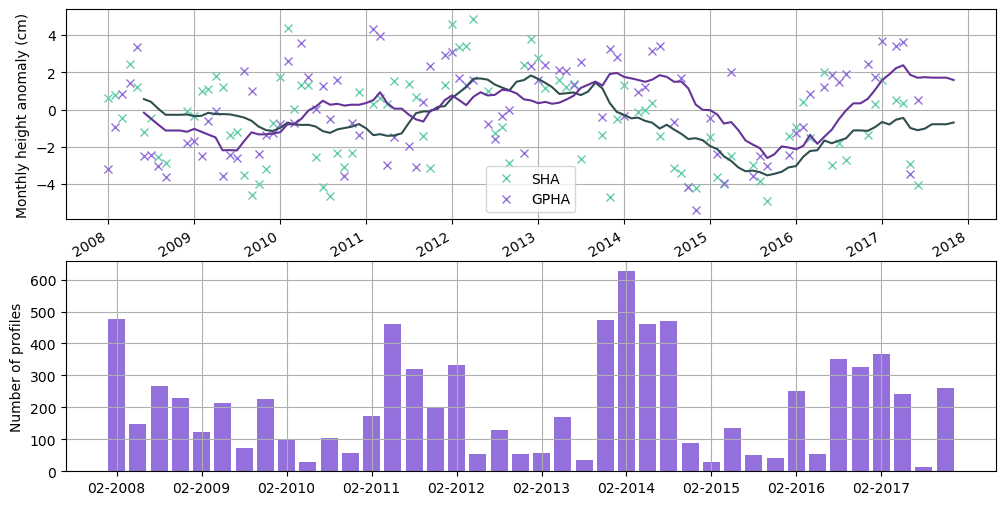

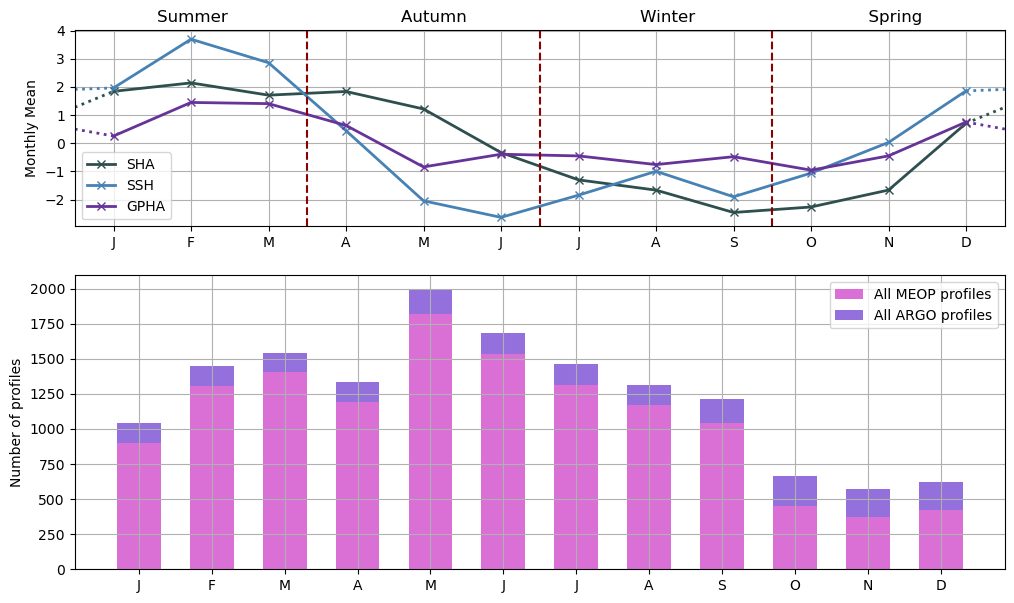

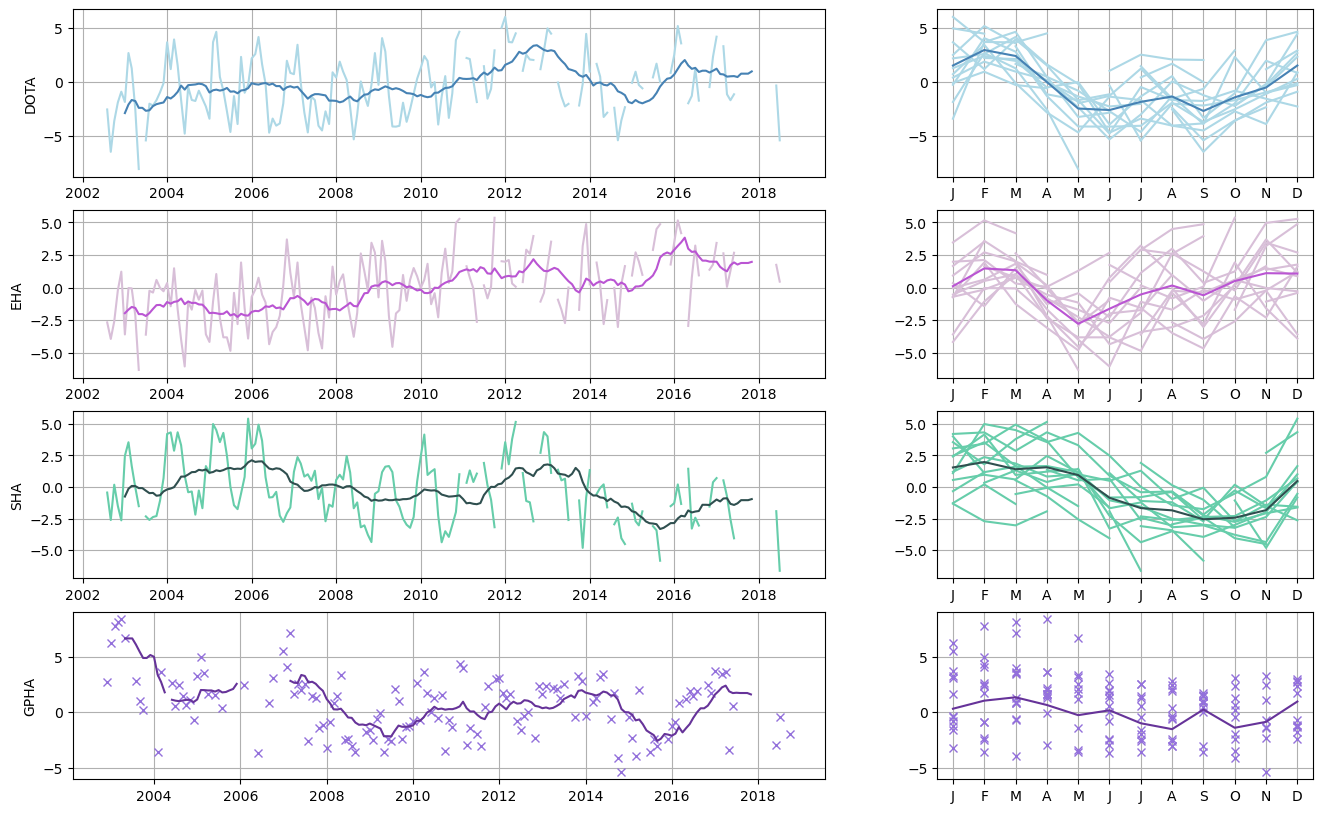

In [25]:
most_profiles = rg('Most profiles',[68,78,-58,-50])

#f1 = plot_profiles_for_region(most_profiles,markersize=10,markerstyle='x')
#most_profiles.plot_region()
f2,ax = timeseries_bar(most_profiles,annual=False)
#most_profiles.plot_cmtlgy(sha_gph.gpha)
f4 = climatology_bar(most_profiles)
f=timeseries_with_cmt(most_profiles)

In [26]:
so = rg('Southern Oce',[-180,180,-90,-50],elevation=gebco_coarse.elevation)

Cropping gebco..
Cropping profile dataframes..
Found MEOP profiles with float IDS: 
[51906 51882 51846 51852 51864 51876 51888 51894 26454 26556 26532 26508
 26526 42864 39990 39978 39966 39996 42858 43812 43818 43824 43836 43878
 43884 43686 43806 43848 43860 43854 43890 43830 43872 44064 44070 26502
 26520 47058 47070 47106 47094 47118 48342 48372 48366 48360 48378 48384
 48390 48252 48258 48264 48270 48276 48294 48288 48246 48306 48312 48318
 48324 48282  9576 49326 49332 49344 49350 49356 49362 49374 50766 58782
 52650 24264 52632 52608 52578 54906 57606 57618 57624 57510 54924 57696
 57690 57684 57630 57648 57702 58686 58692 58872 58884 57678 57672 57660
 54930 57654 57642 60258 54900 62910 62922 62892 62904 62916 62928 63486
 63504 63510 58698 58704 58824 52626 52620 52572 52638 70944 70998 10572
  9618  9654  9606 10578 10584 10608 71442 71454 71412 58842 58812 58818
 58806 58740 58716 58710 58794 58734 58860 58836 58800 58854 58722 71430
 71418 71436 71406 71496 71448 73812 106

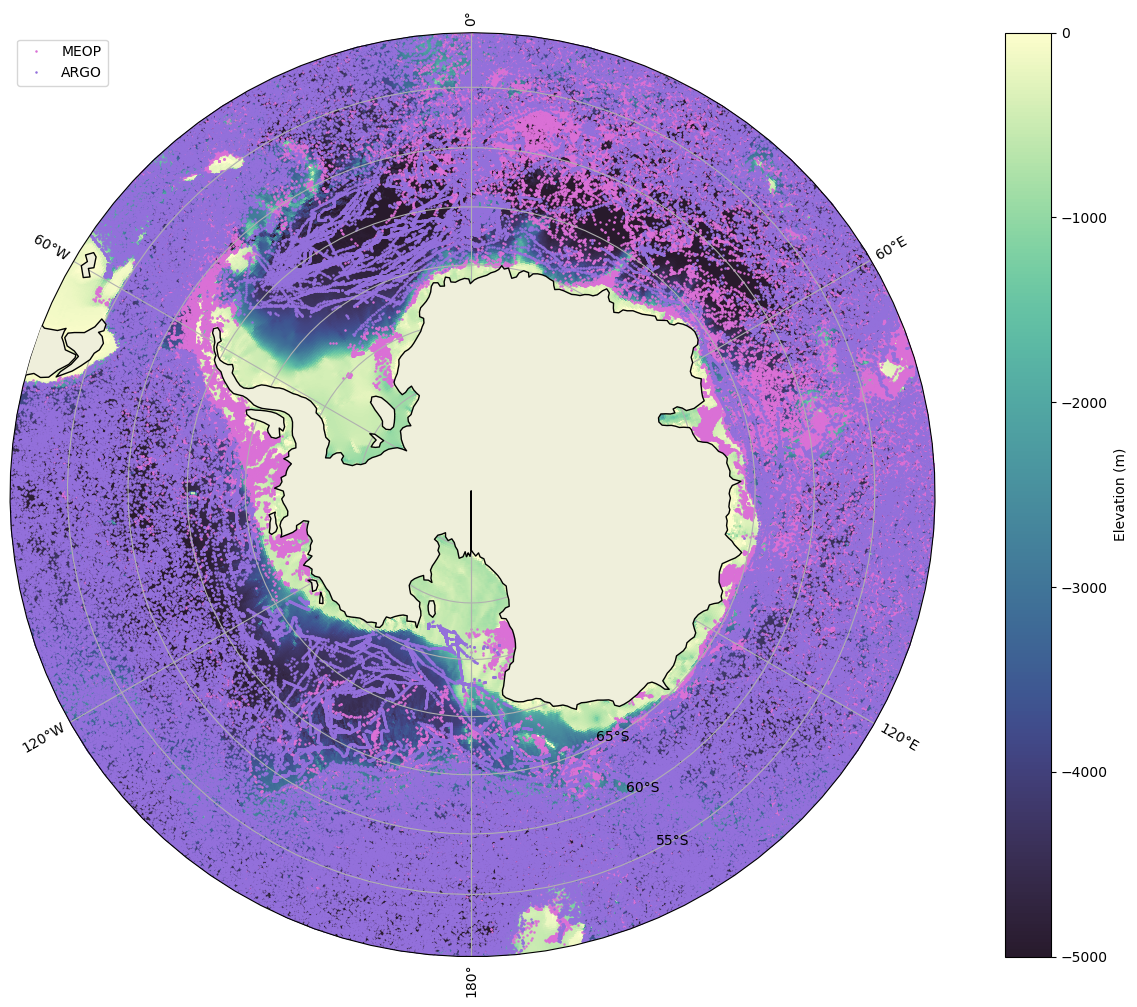

In [27]:
f = plot_profiles_for_region(so,markersize=1.6,markerstyle='.',figsize=(18,12))
#f.savefig('plots/profiles.png',papersize='A0',dpi=200,transparent=True,bbox_inches='tight')

c:\Users\eejco\Anaconda3\envs\sha-env\Lib\site-packages\xarray\core\nputils.py:171: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


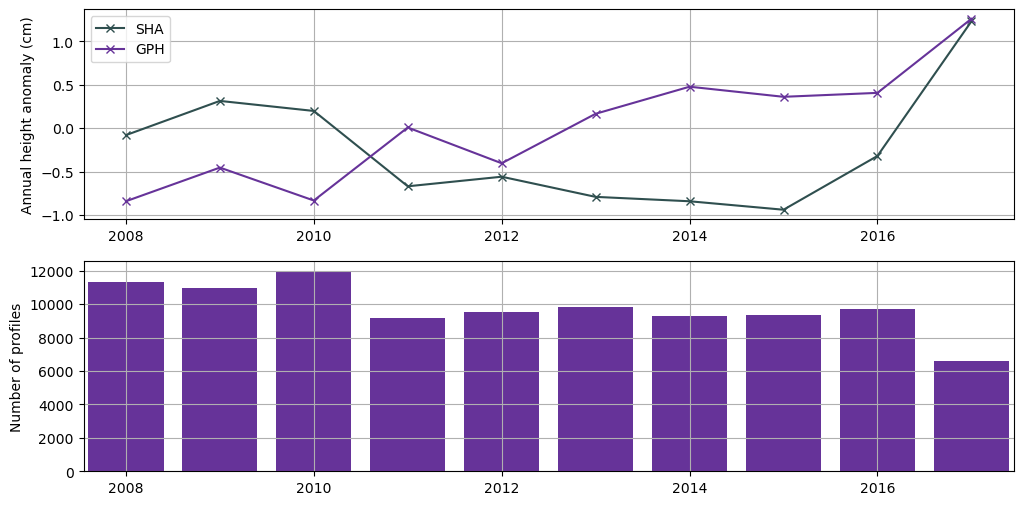

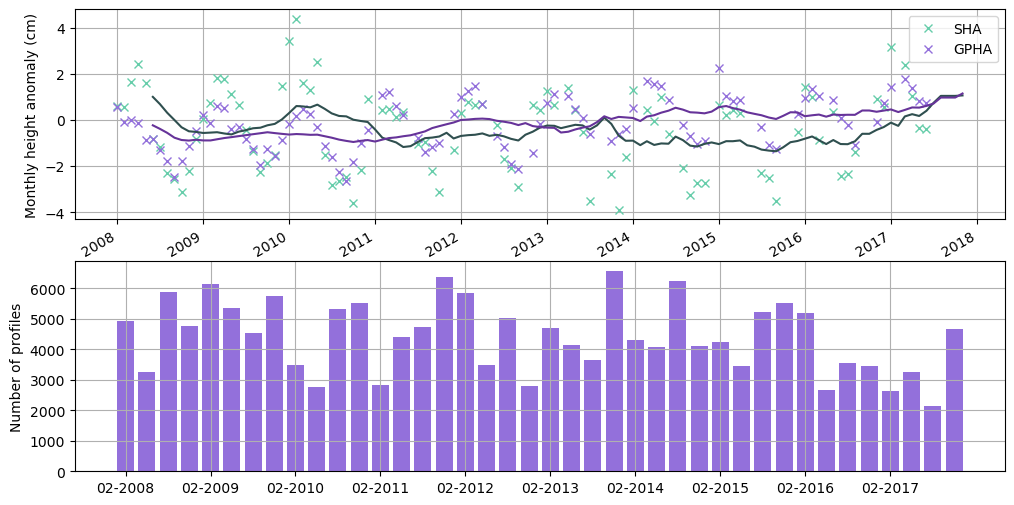

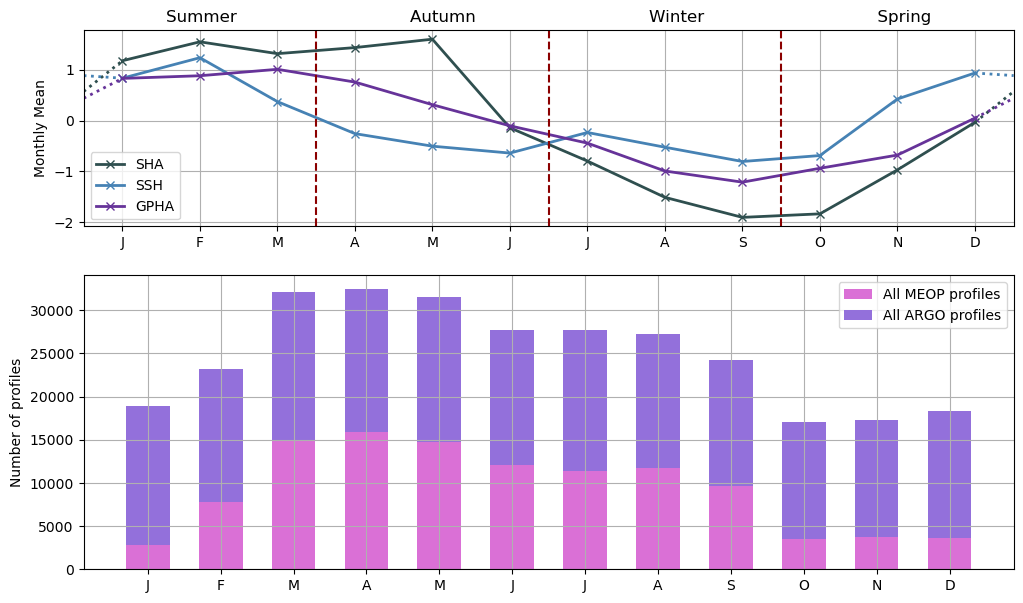

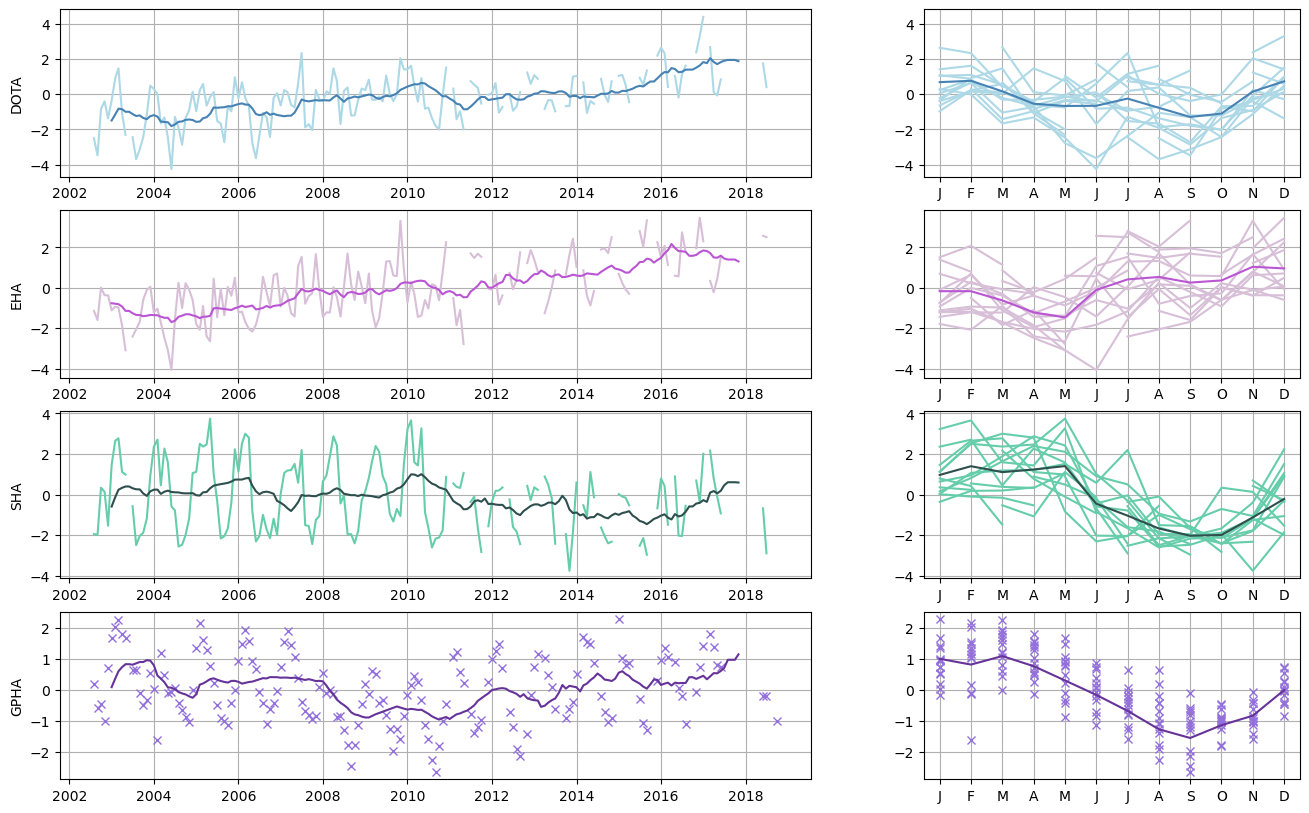

In [28]:
f=timeseries_bar(so)
f=timeseries_bar(so,annual=False)
f=climatology_bar(so)
f=timeseries_with_cmt(so)

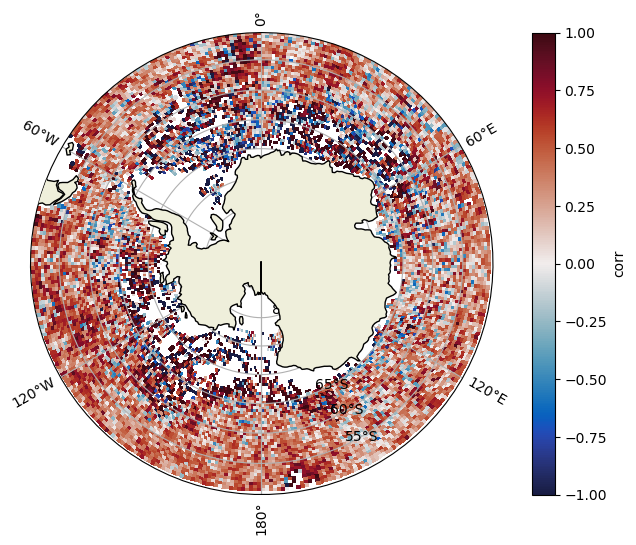

In [315]:
fig,ax = plt.subplots(figsize=(10,6),subplot_kw={'projection': ccrs.SouthPolarStereo()})
pfns.sp(ax,xr.corr(sha_gph.sha,sha_gph.gpha,dim='time'),cmap=cmocean.cm.balance,cbar='corr',cbar_orientation='vertical')

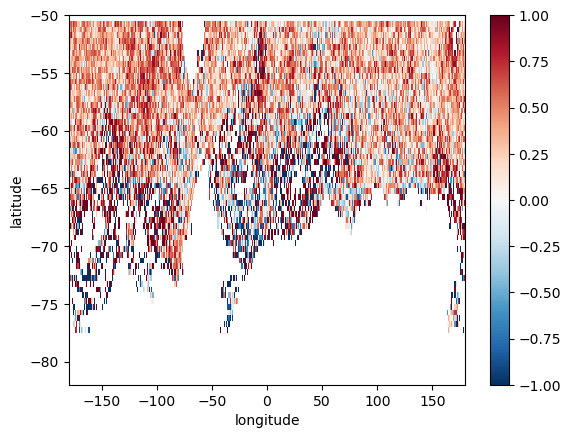

In [309]:
xr.corr(sha_gph.sha,sha_gph.gpha,dim='time').plot()

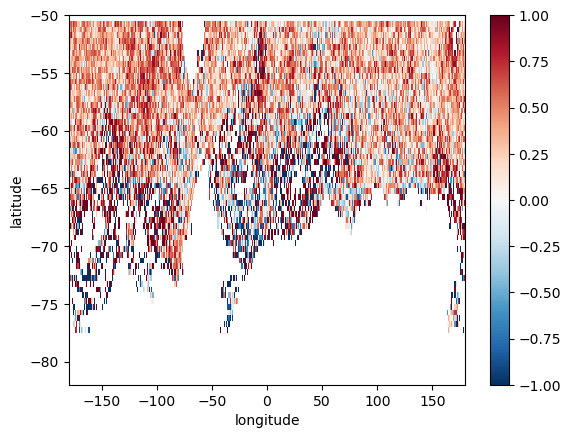

In [307]:
xr.corr(sha_gph.sha,sha_gph.profile_gph,dim='time').plot()

Cropping gebco..
Cropping profile dataframes..
Found MEOP profiles with float IDS: 
[52632 52608 52578 20022 24096 24102 19380 24078 19398 24090 19434 19428
 19422 19446 19440 20016 19998 20010 27492 22044 22014 22074 22008 22050
 22056 22068 22020 21996 22086 22026 27498 22716 22734 22740 26406 26424
 26430 26442 26460 26466 26484 37044 26172 26286 26292 26298 26310 26322
 26328 26334 26358 26340 26346 26352 26364 26370 27378]
Found ARGO profiles with float IDS: 
[5904166]
Plotting bathymetry..
Plotting profile locations.. (markerstyle=x)
Manifesting


c:\Users\eejco\Anaconda3\envs\sha-env\Lib\site-packages\xarray\core\nputils.py:171: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


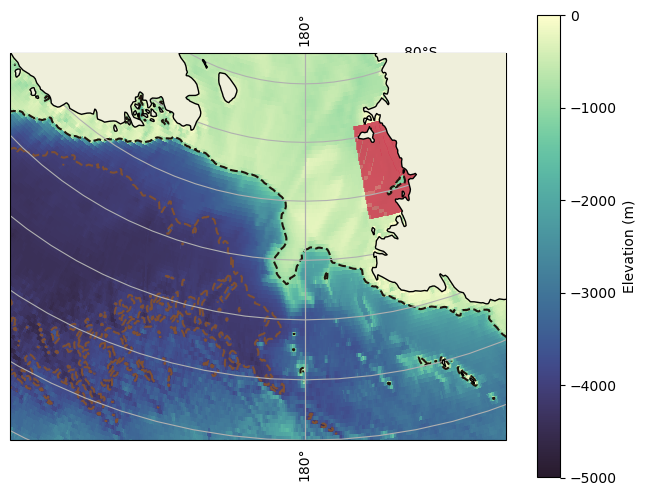

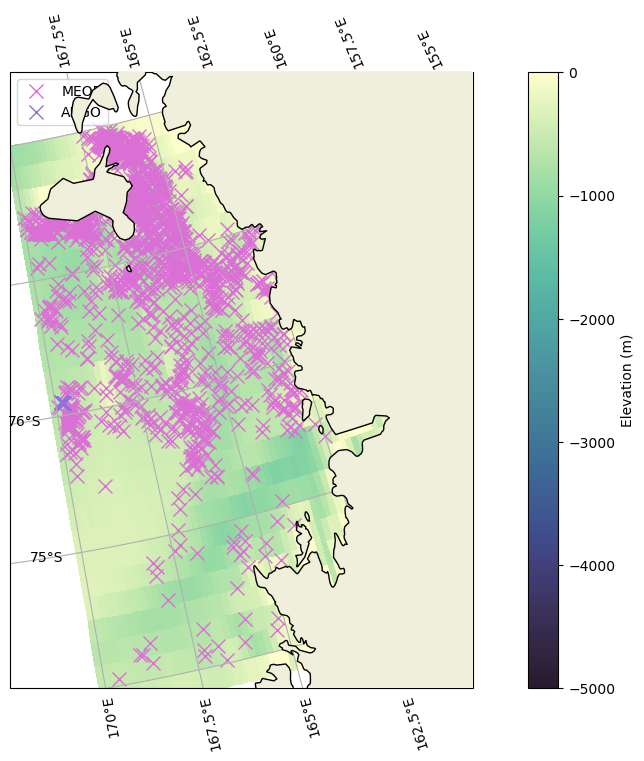

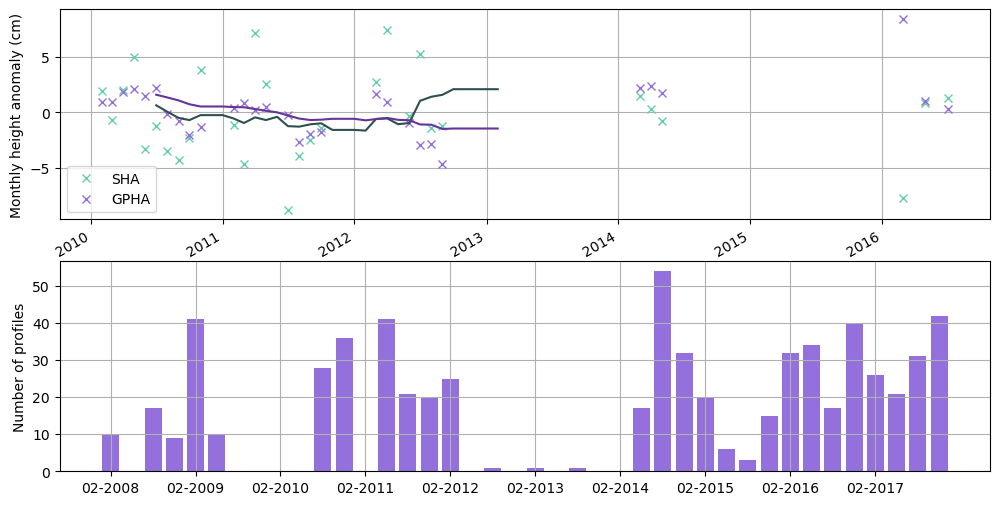

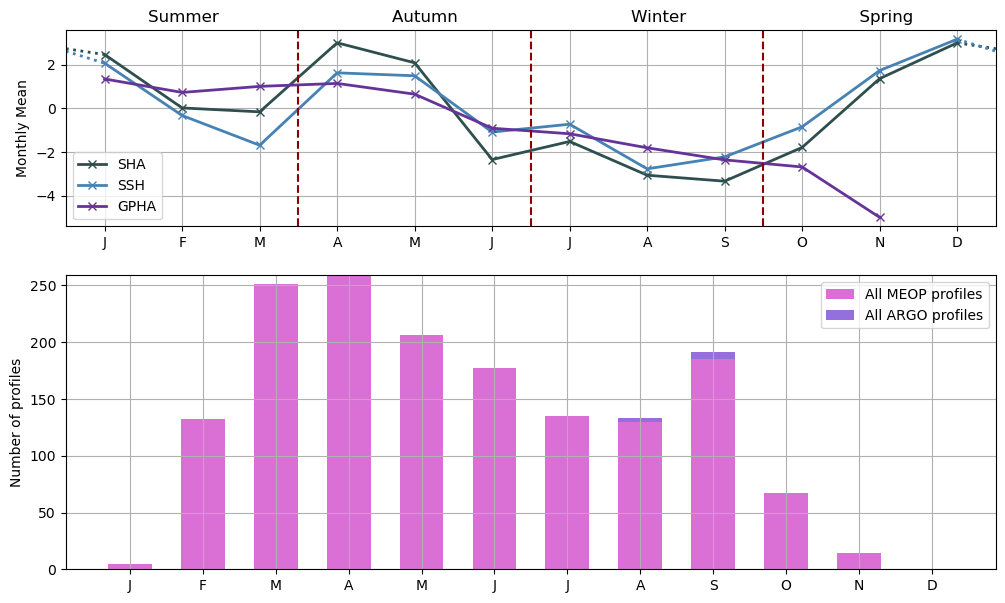

In [30]:
tnb = rg('TNB',[160,170,-78,-74],elevation=gebco_coarse.elevation,min_elevation=-1000)
tnb.plot_region(sea='Ross Sea')
plot_profiles_for_region(tnb,markerstyle='x',markersize=10)#,useall=True)
#rossbit.plot_cmtlgy(sh.gpha)
f2 = timeseries_bar(tnb,annual=False)
f3 = climatology_bar(tnb)

In [11]:
ross_shelf = rg('Ross Ice Shelf',[162,-158,-78,-70],elevation=gebco_coarse.elevation,min_elevation=-1000)
ross_deep = rg('Ross Ice Shelf',[162,-158,-78,-70],elevation=gebco_coarse.elevation,max_elevation=-1000)
ross_all = rg('Ross Ice Shelf',[162,-158,-78,-70],elevation=gebco_coarse.elevation)

In [37]:
ross_profiles=ross_all.crop_df(profiles)
ross_profiles_shelf=ross_shelf.crop_df(profiles)
ross_profiles_deep=ross_deep.crop_df(profiles)

df has no column 'elevation'. trying to interp...


  0%|          | 0/7854 [00:00<?, ?it/s]

In [12]:
ross_profiles['month']=ross_profiles.reset_index().time.dt.month.to_numpy()
ross_profiles_august=ross_profiles[ross_profiles_shelf.month==8]
ross_profiles_august.gph.hist(bins=20)

<AxesSubplot: >

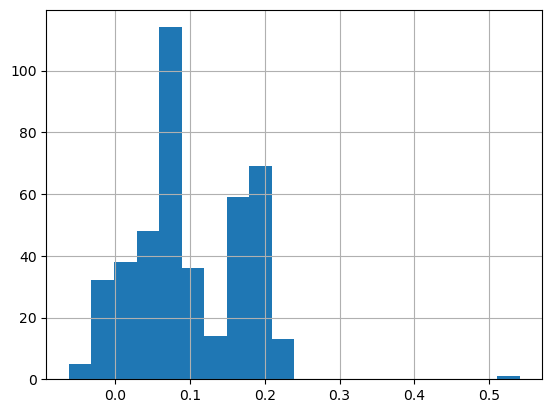

In [39]:
ross_profiles_shelf['month']=ross_profiles_shelf.reset_index().time.dt.month.to_numpy()
ross_profiles_shelf_august=ross_profiles_shelf[ross_profiles_shelf.month==8]
ross_profiles_shelf_august.gph.hist(bins=20)

<AxesSubplot: xlabel='time', ylabel='gph'>

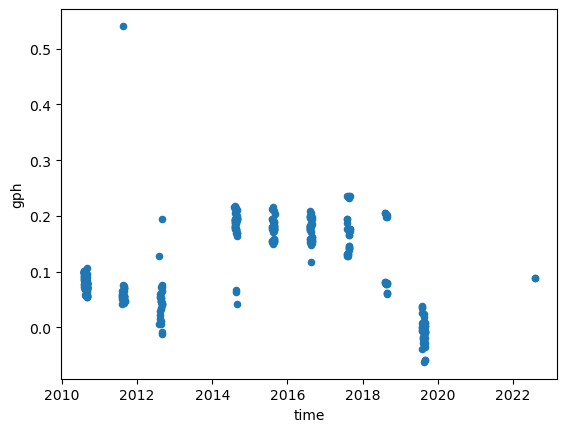

In [53]:
ross_profiles_shelf_august.reset_index().plot.scatter(x='time',y='gph')

In [54]:
ross_profiles_shelf_august

float_type  \
time                                       
2014-08-06 05:27:06.000572160       ARGO   
2014-08-13 01:57:53.000187648       ARGO   
2014-08-19 22:27:50.002395904       ARGO   
2014-08-26 18:58:49.002012416       ARGO   
2014-08-01 09:31:17.001007616       ARGO   
...                                  ...   
2019-08-31 02:09:59.999998000       MEOP   
2019-08-31 21:50:00.000002000       MEOP   
2014-08-19 01:10:00.000001000       MEOP   
2014-08-20 20:40:00.000001000       MEOP   
2014-08-27 01:40:00.000004000       MEOP   

                                                                        filename  \
time                                                                               
2014-08-06 05:27:06.000572160  ../data/ARGO/aoml/5904150/profiles/D5904150_03...   
2014-08-13 01:57:53.000187648  ../data/ARGO/aoml/5904150/profiles/D5904150_03...   
2014-08-19 22:27:50.002395904  ../data/ARGO/aoml/5904150/profiles/D5904150_03...   
2014-08-26 18:58:49.002012416  ../data/ARGO/aoml/5904150/profiles/D5904150_03...   
2014-08-01 09:31:17.001007616  ../data/ARGO/aoml/5904152/profiles/D5904152_03...   
...                                                                          ...   
2019-08-31 02:09:59.999998000                           ct149-922-18_all_prof.nc   
2019-08-31 21:50:00.000002000                           ct149-922-18_all_prof.nc   
2014-08-19 01:10:00.000001000                             ct98-35-13_all_prof.nc   
2014-08-20 20:40:00.000001000                             ct98-35-13_all_prof.nc   
2014-08-27 01:40:00.000004000                             ct98-35-13_all_prof.nc   

                               float_id      lat       lon       gph  month  
time                                                                         
2014-08-06 05:27:06.000572160   5904150 -77.4940 -164.4250  0.216989      8  
2014-08-13 01:57:53.000187648   5904150 -77.4950 -164.4350  0.211850      8  
2014-08-19 22:27:50.002395904   5904150 -77.4960 -164.4450  0.213856      8  
2014-08-26 18:58:49.002012416   5904150 -77.4970 -164.4550  0.211115      8  
2014-08-01 09:31:17.001007616   5904152 -77.5010 -161.9750  0.215086      8  
...                                 ...      ...       ...       ...    ...  
2019-08-31 02:09:59.999998000  00082488 -77.4334  165.9956 -0.009343      8  
2019-08-31 21:50:00.000002000  00082488 -77.5001  166.2359  0.002591      8  
2014-08-19 01:10:00.000001000  00026406 -76.9408  166.7665  0.066272      8  
2014-08-20 20:40:00.000001000  00026406 -77.0392  166.9950  0.063507      8  
2014-08-27 01:40:00.000004000  00026406 -76.9382  167.0506  0.041860      8  

[429 rows x 7 columns]

Interpolating ekevation..


<GeoAxesSubplot: xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

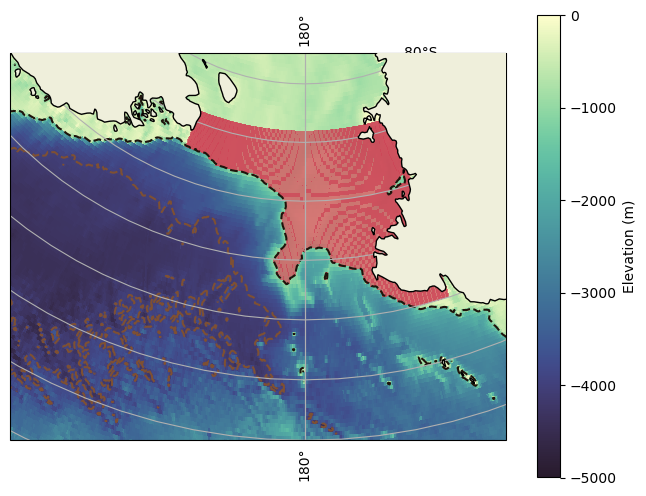

In [6]:
ross_shelf.plot_region(sea='Ross Sea')#extent=[-180,180,-90,-60])

Interpolating ekevation..
Interpolating ekevation..
Interpolating ekevation..


(<Figure size 1600x1000 with 8 Axes>,
 array([[<AxesSubplot: ylabel='DOTA'>, <AxesSubplot: >],
        [<AxesSubplot: ylabel='EHA'>, <AxesSubplot: >],
        [<AxesSubplot: ylabel='SHA'>, <AxesSubplot: >],
        [<AxesSubplot: ylabel='GPHA'>, <AxesSubplot: >]], dtype=object))

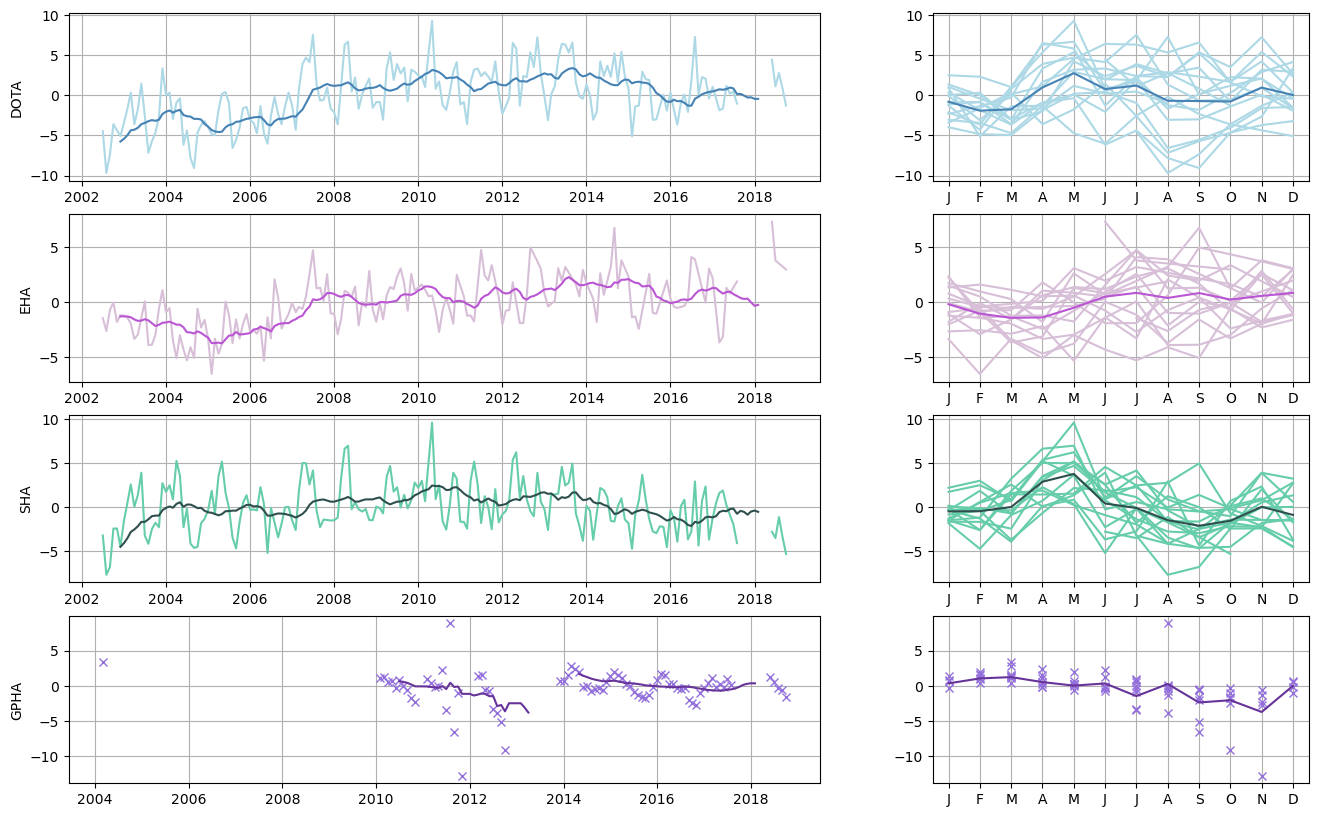

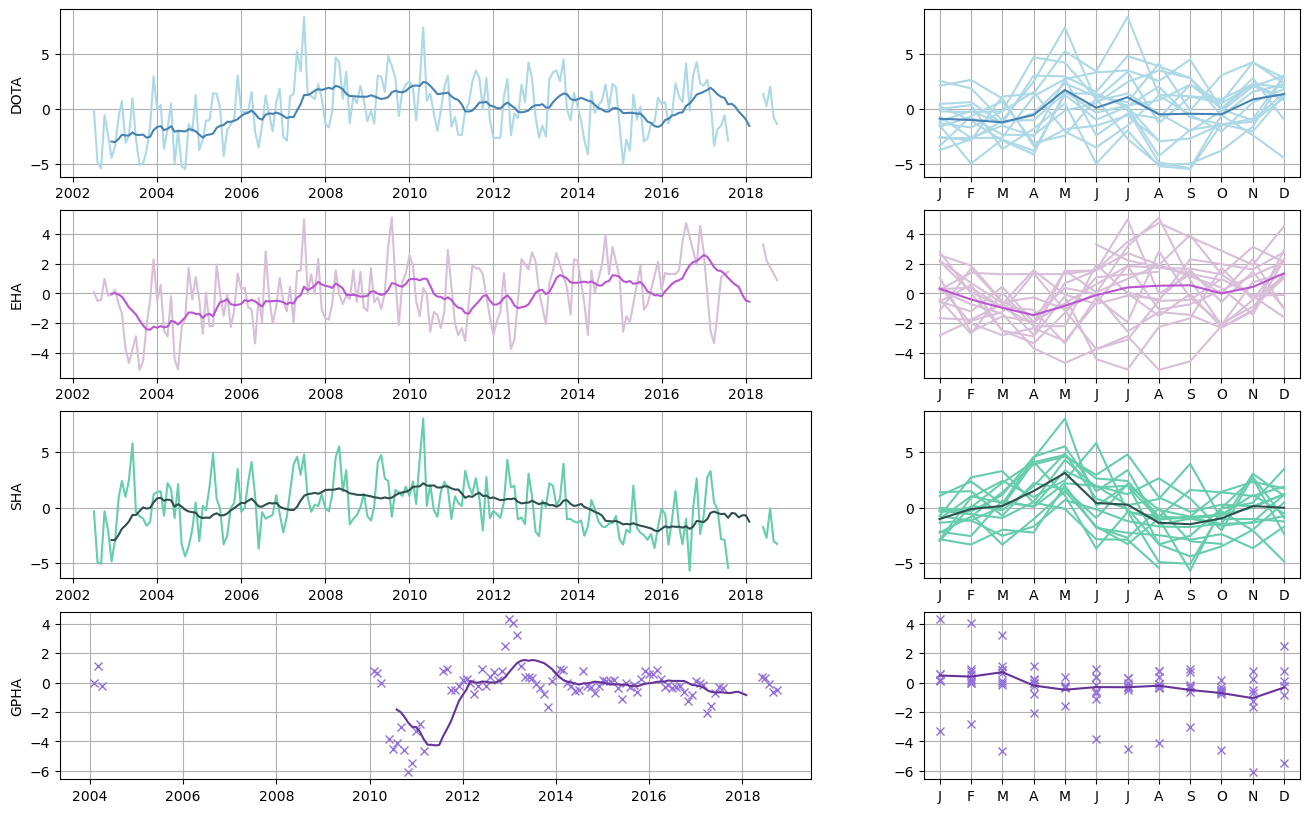

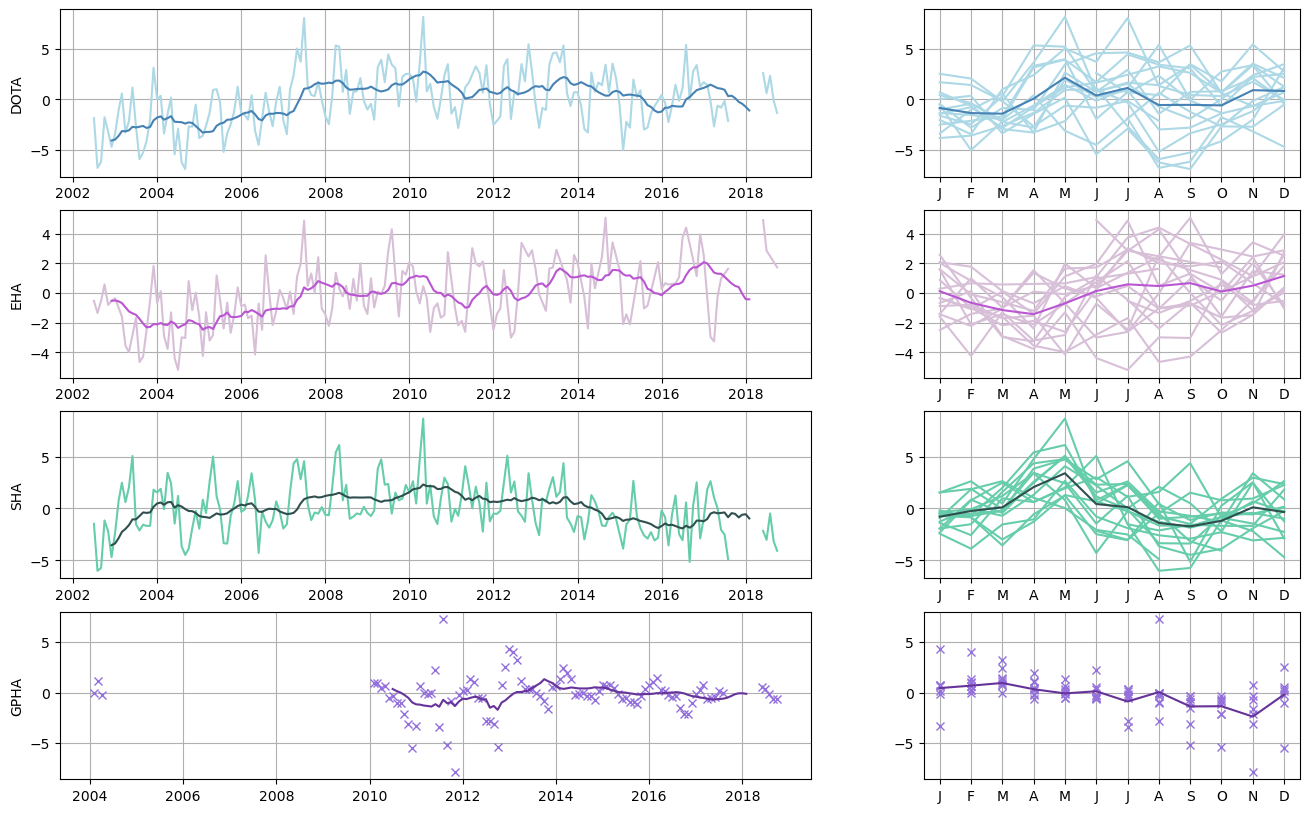

In [299]:
#ross.plot_region()
# f1 = plot_profiles_for_region(ross,markerstyle='x',markersize=6,useall=True)
# f2 = timeseries_bar(ross,annual=False)
# f3 = climatology_bar(ross)
timeseries_with_cmt(ross_shelf)
timeseries_with_cmt(ross_deep)
timeseries_with_cmt(ross_all)

c:\Users\eejco\Anaconda3\envs\sha-env\Lib\site-packages\xarray\core\nputils.py:171: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


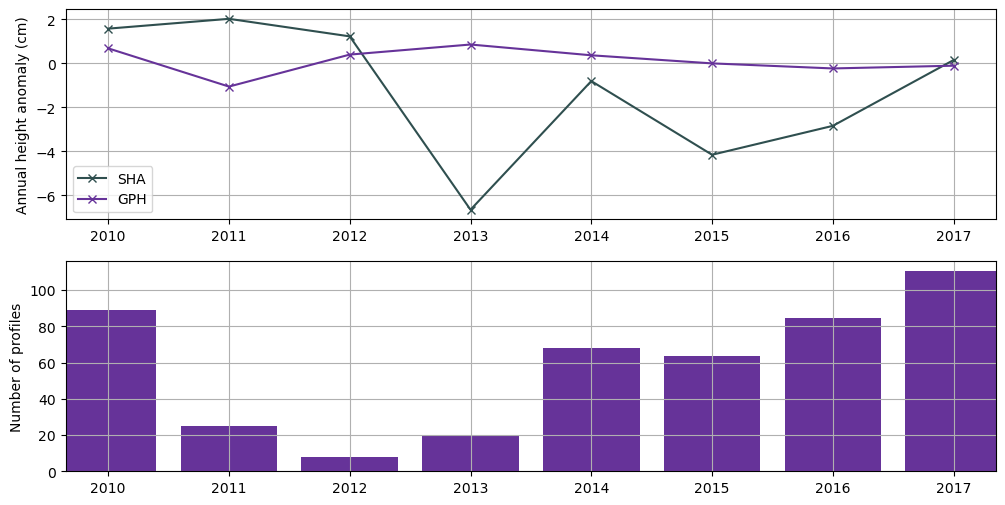

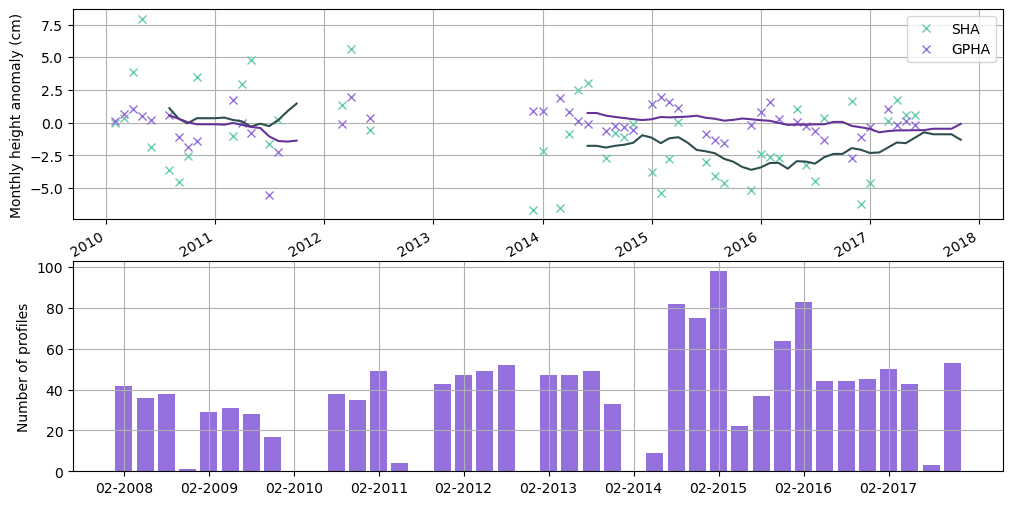

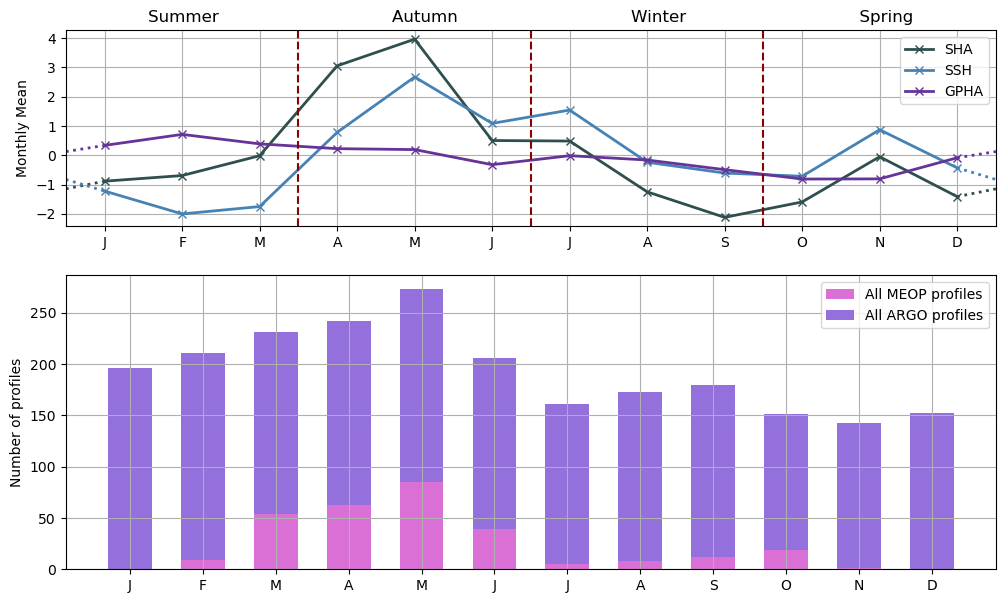

In [31]:
rs = rg("Ross Sea",[170,-150,-85,-70],elevation=gebco_coarse.elevation,min_elevation=-1000)
f2 = timeseries_bar(rs)
f3 = timeseries_bar(rs,annual=False)
f4 = climatology_bar(rs)

Interpolating ekevation..


<GeoAxesSubplot: xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

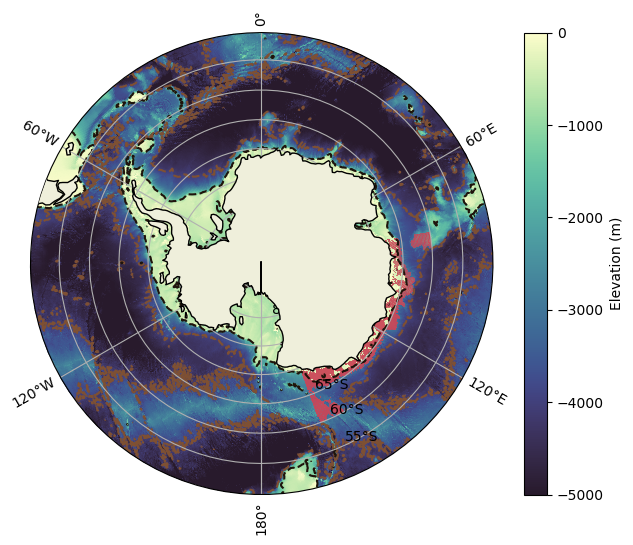

In [70]:
eas = rg('East Antarctic Shelf',[80,160,-85,-60],elevation=gebco_coarse.elevation,max_elevation=-400,min_elevation=-3000)
eas.plot_region()

In [ ]:
f1 = plot_profiles_for_region(most_profiles,markersize=10,markerstyle='x')
most_profiles.plot_region()
f2,ax = timeseries_bar(most_profiles,annual=False)
most_profiles.plot_cmtlgy(sha_gph.gpha)
f4 = climatology_bar(most_profiles)
f=timeseries_with_cmt(most_profiles)